# **Simple Recommender**

The Simple Recommender provides users with generalized recommendations based on genre and movie rating/popularity. The underlying premise behind this recommender is that popular movies are more likely to be liked by the average audience. This model does not provide personalized recommendations based on the user's preferences.

The model is implemented as follows: 
1. rank movies based on IMDB formula
2. sort movies by this rating mechanism (e.g get the top 10 movies) 
3. pass in a genre argument to find the best movies in a specific genre 
4. add addtion filters to expand this recommender 

In [1]:
# import libraries 
from scipy.stats import wilcoxon
import pandas as pd
import numpy as np
from ast import literal_eval
from collections import Counter
from matplotlib import pyplot as plt

import warnings; warnings.simplefilter('ignore')

In [2]:
# load the dataset

md = pd.read_csv('data/movies_metadata.csv',low_memory=False)
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


We can then pre-process/clean this dataset:

In [3]:
# For the colum genres: 

# fill all instances of NA/NaN values with '[]' as the genre column is supposed to be a list
# (literal_eval) evaluate strings in terms of dictionaries
# The function at the end will return all dictionary values associated with key name within your inputs if they're lists. Otherwise, that'll be an empty list.

md['genres_list'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


We can use the IMDB weighted ratings to come up with our Top Movies Chart. It is represented as follows:

Weighted Rating (WR) =  (v/(v+m)*R)+(m/(v+m)*C) where,

1. v is the number of votes for the movie
2. m is the minimum votes required to be listed in the chart
3. R is the average rating of the movie
4. C is the mean vote across the whole report

The next step is to determine an appropriate value for v ,m ,R and C, and write a function to calculate the weighted rating. 

In [4]:
m = md['vote_count'].quantile(0.95)
C = md['vote_average'].mean()
v = md['vote_count']
R = md['vote_average']

In [5]:
m

434.0

In [6]:
C

5.618207215134185

Therefore, to qualify to be considered for the chart, a movie has to have at least **434** TMDB votes. We also see that the average rating for a movie on is **5.618** on a scale of 10. 

We can create a dataframe to sort out the movies based on their ratings.

1. fix the release_date to just year, because no one really care the actual date.
2. Runtime of the moive should be integers. 
3. the weighted_rating rounds to 1 decimal. 

In [7]:
# only include the year the movie comes out 

md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [8]:
Mycolumns = ['title','original_language','year','runtime','genres_list','vote_count','vote_average'] 

dataframe=md[Mycolumns]

In [9]:
# calculate the weighted_rating

dataframe['weighted_rating'] = ((v/(v+m) * R) + (m/(m+v) * C))

In [10]:
TOP_rated = dataframe[(dataframe["vote_count"] >= m) & (dataframe['vote_count'].notnull()) & (dataframe['runtime'].notnull())]

TOP_rated['vote_count'] = TOP_rated['vote_count'].astype('int')
TOP_rated['runtime'] = TOP_rated['runtime'].astype('int')
TOP_rated['weighted_rating']=TOP_rated['weighted_rating'].round(decimals = 1)

In [11]:
TOP_rated.head()

,title,original_language,year,runtime,genres_list,vote_count,vote_average,weighted_rating
0,Toy Story,en,1995,81,"[Animation, Comedy, Family]",5415,7.7,7.5
1,Jumanji,en,1995,104,"[Adventure, Fantasy, Family]",2413,6.9,6.7
5,Heat,en,1995,170,"[Action, Crime, Drama, Thriller]",1886,7.7,7.3
9,GoldenEye,en,1995,130,"[Adventure, Action, Thriller]",1194,6.6,6.3
15,Casino,en,1995,178,"[Drama, Crime]",1343,7.8,7.3


In [12]:
TOP_rated.shape

(2274, 8)

In total, we have 2274 movies that qualify to be on our chart. We can further demonstrate the **top 10 movies** using this dataset. 

In [13]:
# demonstrate the top 10 movies in our chart 

TOP_rated.sort_values('weighted_rating', ascending=False).head(10)

,title,original_language,year,runtime,genres_list,vote_count,vote_average,weighted_rating
314,The Shawshank Redemption,en,1994,142,"[Drama, Crime]",8358,8.5,8.4
834,The Godfather,en,1972,175,"[Drama, Crime]",6024,8.5,8.3
12481,The Dark Knight,en,2008,152,"[Drama, Action, Crime, Thriller]",12269,8.3,8.2
292,Pulp Fiction,en,1994,154,"[Thriller, Crime]",8670,8.3,8.2
2843,Fight Club,en,1999,139,[Drama],9678,8.3,8.2
522,Schindler's List,en,1993,195,"[Drama, History, War]",4436,8.3,8.1
351,Forrest Gump,en,1994,142,"[Comedy, Drama, Romance]",8147,8.2,8.1
23673,Whiplash,en,2014,105,[Drama],4376,8.3,8.1
3030,The Green Mile,en,1999,189,"[Fantasy, Drama, Crime]",4166,8.2,8.0
289,Leon: The Professional,fr,1994,110,"[Thriller, Crime, Drama]",4293,8.2,8.0


# **Genre-based Recommender**

The next step is to consider the **genre** of the movie, and recommend popular movies in a specific domain. 

In [14]:
# separate the genre lists for each movie 

s = md.apply(lambda x: pd.Series(x['genres_list']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres_list', axis=1).join(s)

In [15]:
# First, we can have an idea of how many genres there are

l_genres = md['genres'].apply(literal_eval).apply(lambda x: [i['name'] for i in x]).sum()
count_genres=Counter(l_genres)

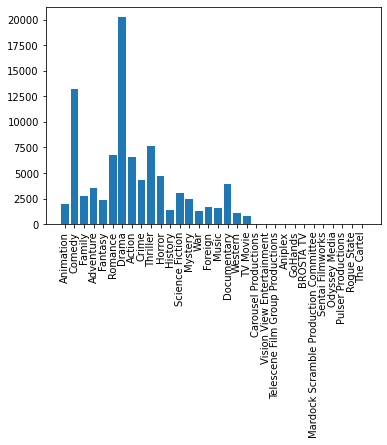

In [16]:
# plot a diagram to show the distributions of genres 

plt.bar(count_genres.keys(), count_genres.values())
plt.xticks(rotation='vertical')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

There are over **20000** movies categorised as "Drama" and around **12500** movies classified as "Comedy." There are also a great number of films categorised as "Romance," "Action," and "Thriller."

In [17]:
# build a function that takes a specific genre and a percentile and outputs top 250 movies based on their ratings. 

def build_genre_chart(genre, percentile):
    df = gen_md[gen_md['genre'] == genre]
    C = df['vote_average'].mean()
    m = df['vote_count'].quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull())][['title','original_language', 'year', 'runtime', 'vote_count', 'vote_average']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['runtime'] = qualified['runtime'].astype('int')
    
    qualified['IMDB_rating'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified['IMDB_rating']=qualified['IMDB_rating'].round(decimals = 1)
    qualified = qualified.sort_values('IMDB_rating', ascending=False).head(250)
    
    return qualified

In [18]:
build_genre_chart('Romance',0.85).head(15)

,title,original_language,year,runtime,vote_count,vote_average,IMDB_rating
10309,Dilwale Dulhania Le Jayenge,hi,1995,190,661,9.1,8.7
40251,Your Name.,ja,2016,106,1030,8.5,8.3
351,Forrest Gump,en,1994,142,8147,8.2,8.2
1132,Cinema Paradiso,it,1988,124,834,8.2,8.0
22168,Her,en,2013,126,4215,7.9,7.9
40882,La La Land,en,2016,128,4745,7.9,7.9
7208,Eternal Sunshine of the Spotless Mind,en,2004,108,3758,7.9,7.9
19901,Paperman,en,2012,7,734,8.0,7.8
15530,Mr. Nobody,en,2009,156,1616,7.9,7.8
3189,City Lights,en,1931,87,444,8.2,7.8


**Next step:**

1. We may also compare how much the 'IMDB rating' differs from the 'vote average.'

2. We can consider additional features such as original language, year, or runtime and combines all of these features to create a more complete chart/recommender.

In [19]:
# compare the differences in the rating scores 

difference=[]

zip_object = zip(TOP_rated['weighted_rating'], TOP_rated['vote_average'])
for list1_i, list2_i in zip_object:
    difference.append(list1_i-list2_i)

w, p = wilcoxon(difference, alternative="less")
print(w,p)

107515.5 3.2036404180469513e-279


The null hypothesis that there is no score difference can be rejected. In addition, the null hypothesis that the median is positive can be rejected in favor of the alternative that the median is less than zero.

The "weighted_rating" generally results a lower rating. 

# **Genre-based Recommender with additional features**

The codes below attempt to add more attributes to the movie filter and recommend popular movies accordingly.

In [20]:
# build a function that takes a specific language and a percentile and outputs top 250 movies based on their ratings. 

def build_language_chart(genre, language, percentile):
    df = gen_md[gen_md['genre'] == genre]
    df = df[df['original_language'] == language]
    C = df['vote_average'].mean()
    m = df['vote_count'].quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull())][['title','original_language', 'year', 'runtime', 'vote_count', 'vote_average']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['runtime'] = qualified['runtime'].astype('int')
    
    qualified['IMDB_rating'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified['IMDB_rating']=qualified['IMDB_rating'].round(decimals = 1)
    qualified = qualified.sort_values('IMDB_rating', ascending=False).head(250)
    
    return qualified

In [21]:
# build a chart that shows the Top-15 rated japanese animations 

build_language_chart("Animation","ja", 0.85).head(15)

,title,original_language,year,runtime,vote_count,vote_average,IMDB_rating
40251,Your Name.,ja,2016,106,1030,8.5,8.3
5481,Spirited Away,ja,2001,125,3968,8.3,8.2
9698,Howl's Moving Castle,ja,2004,119,2049,8.2,8.1
2884,Princess Mononoke,ja,1997,134,2041,8.2,8.1
5553,Grave of the Fireflies,ja,1988,89,974,8.2,8.0
5833,My Neighbor Totoro,ja,1988,86,1730,8.0,7.9
6212,Castle in the Sky,ja,1986,124,877,7.8,7.7
20779,Wolf Children,ja,2012,117,483,8.0,7.7
1229,Akira,ja,1988,124,792,7.8,7.6
6947,Nausicaä of the Valley of the Wind,ja,1984,117,808,7.7,7.6


In [22]:
# build a function that takes two additional filters (i.e language and year) and a percentile and outputs top 250 movies based on their ratings.

def build_full_chart(genre, language, year, percentile):
    df = gen_md[gen_md['genre'] == genre]
    df = df[df['original_language'] == language]
    # if a year is specified
    if year is not '/':
        df = df[df['year'] == year]    
    C = df['vote_average'].mean()
    m = df['vote_count'].quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull())][['title','original_language', 'year', 'runtime', 'vote_count', 'vote_average']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['runtime'] = qualified['runtime'].astype('int')
    
    qualified['IMDB_rating'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified['IMDB_rating']=qualified['IMDB_rating'].round(decimals = 1)
    chart= qualified.sort_values('IMDB_rating', ascending=False).head(250)
    # if a year is not specified (then rank movies from the newest to the oldest)
    if year is '/':
        chart=qualified.sort_values(['year', 'IMDB_rating'], ascending=[False, False]).head(250)
        
    return chart


In [23]:
# English action movies in 2012

build_full_chart("Action","en","2012",0.85).head(10)

,title,original_language,year,runtime,vote_count,vote_average,IMDB_rating
18252,The Dark Knight Rises,en,2012,165,9263,7.6,7.3
17818,The Avengers,en,2012,143,12000,7.4,7.2
19735,Life of Pi,en,2012,127,5912,7.2,6.8
19971,The Hobbit: An Unexpected Journey,en,2012,169,8427,7.0,6.7
19261,Skyfall,en,2012,143,7718,6.9,6.6
19071,Brave,en,2012,93,4760,6.7,6.4
18723,21 Jump Street,en,2012,109,4151,6.7,6.3
19129,The Amazing Spider-Man,en,2012,136,6734,6.5,6.3
19394,Looper,en,2012,118,4777,6.6,6.3
18972,Men in Black 3,en,2012,106,4228,6.3,6.1


In [24]:
# English action movies ranked from the newest to the oldest 

build_full_chart("Action","en","/",0.85).head(10)

,title,original_language,year,runtime,vote_count,vote_average,IMDB_rating
42170,Logan,en,2017,137,6310,7.6,7.5
26566,Guardians of the Galaxy Vol. 2,en,2017,137,4858,7.6,7.4
44678,Dunkirk,en,2017,107,2712,7.5,7.2
33356,Wonder Woman,en,2017,141,5025,7.2,7.1
43644,Baby Driver,en,2017,113,2083,7.2,6.9
41976,The Lego Batman Movie,en,2017,104,1473,7.2,6.8
43255,The Fate of the Furious,en,2017,136,3803,6.8,6.7
26560,Pirates of the Caribbean: Dead Men Tell No Tales,en,2017,129,2814,6.6,6.5
42168,John Wick: Chapter 2,en,2017,122,2924,6.7,6.5
42214,King Arthur: Legend of the Sword,en,2017,126,1506,6.5,6.3


We can consider the movie's **runtime** to be an innovative filtering condition. It is occasionally critical for users to assess the length of the film before they watch movies. If you only have two hours to spare, a movie that lasts one hour to one and a half hours is a better pick than a movie like "007," which lasts two and a half hours.

As a result, the runtime filter would be as follows:
1. Fisrt, there are several options for suggesting a movie time (i.e, 60, 90, 120, 150, 180 minutes).
2. Users could select one of the options listed above.
3. After that, movies are ranked based on their time difference from the prescribed time (the closer the movie's runtime is to the suggested time, the more likely it will be recommended).

In [25]:
# runtime filter

def build_runtime_chart(genre, runtime, percentile):
    df = gen_md[gen_md['genre'] == genre]
    C = df['vote_average'].mean()
    m = df['vote_count'].quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull())][['title','original_language', 'year', 'runtime', 'vote_count', 'vote_average']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['runtime'] = qualified['runtime'].astype('int')
    qualified['time_diff']=abs(qualified['runtime']-runtime)
    
    qualified['IMDB_rating'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified['IMDB_rating']=qualified['IMDB_rating'].round(decimals = 1)
    qualified=qualified.sort_values(['IMDB_rating', 'time_diff'], ascending=[False, True]).head(250)
    
    return qualified

In [26]:
# recommend top 10 comedy movies that runs approximately two hours 

build_runtime_chart("Comedy",120,0.95).head(10)

,title,original_language,year,runtime,vote_count,vote_average,time_diff,IMDB_rating
351,Forrest Gump,en,1994,142,8147,8.2,22,8.1
2211,Life Is Beautiful,it,1997,116,3643,8.3,4,8.0
18465,The Intouchables,fr,2011,112,5410,8.2,8,8.0
1225,Back to the Future,en,1985,116,6239,8.0,4,7.8
22841,The Grand Budapest Hotel,en,2014,99,4644,8.0,21,7.8
40882,La La Land,en,2016,128,4745,7.9,8,7.7
13724,Up,en,2009,96,7048,7.8,24,7.7
30315,Inside Out,en,2015,94,6737,7.9,26,7.7
22131,The Wolf of Wall Street,en,2013,180,6768,7.9,60,7.7
1604,The Truman Show,en,1998,103,4702,7.8,17,7.6


**Top Hits**

Sometime people are only interested in the popular films, this can be reflected on the vote counts. Based on that we built a popularity filter that returns popular movies which their vote counts are above a threshold (ex. top 5%, top 1%).

In [36]:
def build_popularity_chart(genre, percentile):
    df = gen_md[gen_md['genre'] == genre]
    C = df['vote_average'].mean()
    m = df['vote_count'].quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull())][['title','original_language', 'year', 'runtime', 'vote_count', 'vote_average']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['runtime'] = qualified['runtime'].astype('int')
    
    qualified['IMDB_rating'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified['IMDB_rating']=qualified['IMDB_rating'].round(decimals = 1)
    qualified = qualified.sort_values('vote_count', ascending=False).head(250)
    
    return qualified

In [37]:
build_popularity_chart("Comedy", 0.85).head(10)

,title,original_language,year,runtime,vote_count,vote_average,IMDB_rating
26564,Deadpool,en,2016,108,11444,7.4,7.4
351,Forrest Gump,en,1994,142,8147,8.2,8.2
13724,Up,en,2009,96,7048,7.8,7.8
22131,The Wolf of Wall Street,en,2013,180,6768,7.9,7.9
30315,Inside Out,en,2015,94,6737,7.9,7.9
13746,The Hangover,en,2009,100,6324,7.2,7.2
24455,Big Hero 6,en,2014,102,6289,7.8,7.8
1225,Back to the Future,en,1985,116,6239,8.0,8.0
4756,"Monsters, Inc.",en,2001,92,6150,7.5,7.5
25534,Kingsman: The Secret Service,en,2015,130,6069,7.6,7.6


**Dirctor and Cast Filter** (unfinished)

Now we add filter options that is built on actor/director name.


In [39]:
credits = pd.read_csv('data/credits.csv')
credits['id'] = credits['id'].astype('int')

In [43]:
#id errors
print(md['id'][19730])
md_fix = md.drop([19730, 29503, 35587])

1997-08-20


In [45]:
md_fix['id'] = md_fix['id'].astype('int')
md_fix = md_fix.merge(credits, on='id')

In [46]:
md_fix.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,genres_list,year,cast,crew
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,"[Animation, Comedy, Family]",1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[Adventure, Fantasy, Family]",1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[Romance, Comedy]",1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[Comedy, Drama, Romance]",1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,[Comedy],1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


Now we need to make choice on the cast and crew member we desire to keep. For this, we chose only the director from the crew and top 5 actors in the cast list since they contributes most to the film and are the most likely the selection critiria of a film.

In [47]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
md_fix['director'] = md_fix['crew'].apply(get_director)

In [49]:
md_fix['cast'] = md_fix['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
md_fix['cast'] = md_fix['cast'].apply(lambda x: x[:5] if len(x) >=5 else x)